# Introduction

Notebook for training deep neural networks to estimate the compliance of an image to the MOUTH requisite.

The training is supervised and labels were obtained through the running of the MouthOpenface model followed by a Tagger execution
with a threshold of 0.1.

# Import Libraries and Dependencies

In [258]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [259]:
import os
import sys
import cv2
import random
import datetime
import neptune
import tempfile
import numpy as np
import pandas as pd

from imutils import paths

import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as prep_input_mobilenetv2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import LambdaCallback, EarlyStopping, LearningRateScheduler

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


if '../../../notebooks/' not in sys.path:
    sys.path.append('../../../notebooks/')

import utils.constants as cts
import utils.draw_utils as dr

from models.oface_mouth_model import OpenfaceMouth

from data_loaders.data_loader import DLName

from net_data_loaders.net_data_loader import NetDataLoader

import utils.draw_utils as dr

import fqa.faceqnet.faceqnet_utils as fqnet

# from gt_loaders.gen_gt import Eval
# from gt_loaders.fvc_gt import FVC_GTLoader
# from gt_loaders.pybossa_gt import PybossaGTLoader

# Load Data and Labels

In [260]:
m = OpenfaceMouth()
req = cts.ICAO_REQ.MOUTH
dl_names = [x for x in DLName]

netDataLoader = NetDataLoader(m, req, dl_names, True)
in_data = netDataLoader.load_data()

Input data.shape: (26722, 4)


# Data Selection

Based on Face Quality Assessment (FaceQNet v1)

In [170]:
fqnet.load_faceqnet()

In [172]:
in_data['fqa_score'] = in_data.img_name.apply(lambda img : fqnet.run_faceqnet({'img':img})[0])

In [173]:
in_data.head()

,origin,img_name,comp,aligned,fqa_score
0,fvc_pybossa,/home/guilherme/data/Dropbox/Link to Desktop/D...,1.0,True,0.445449
1,fvc_pybossa,/home/guilherme/data/Dropbox/Link to Desktop/D...,0.0,True,0.544804
2,fvc_pybossa,/home/guilherme/data/Dropbox/Link to Desktop/D...,0.0,True,0.613707
3,fvc_pybossa,/home/guilherme/data/Dropbox/Link to Desktop/D...,0.0,True,0.606171
4,fvc_pybossa,/home/guilherme/data/Dropbox/Link to Desktop/D...,1.0,True,0.570472


In [179]:
in_data.origin.unique()

array(['fvc_pybossa', 'caltech', 'vgg', 'cvl', 'color_feret', 'fei',
       'georgia_tech', 'uni_essex', 'icpr04', 'imfdb', 'lfw', 'celeba'],
      dtype=object)

In [185]:
in_data.groupby('origin').fqa_score.mean()

origin
caltech         0.571987
celeba          0.431980
color_feret     0.547891
cvl             0.523345
fei             0.546468
fvc_pybossa     0.550484
georgia_tech    0.559628
icpr04          0.551269
imfdb           0.532781
lfw             0.538839
uni_essex       0.506958
vgg             0.522527
Name: fqa_score, dtype: float64

In [248]:
in_data.fqa_score.describe()

count    26722.000000
mean         0.522810
std          0.071413
min          0.069526
25%          0.473706
50%          0.526247
75%          0.573191
max          0.799987
Name: fqa_score, dtype: float64

In [255]:
in_data[in_data.fqa_score > 0.52].shape[0]

14203

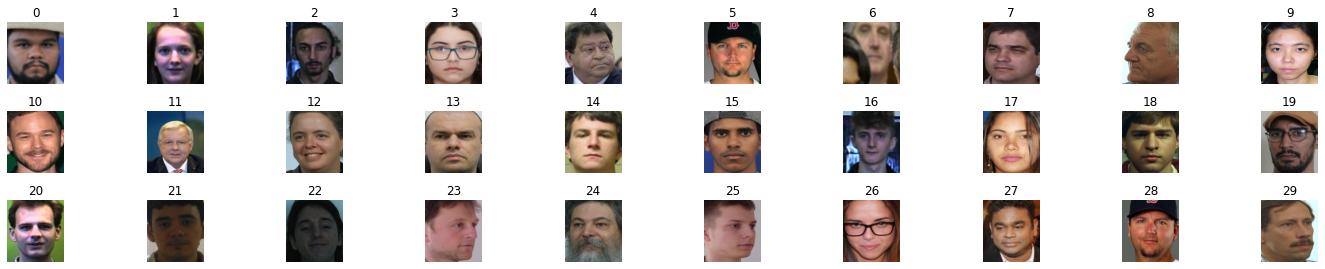

In [256]:
import cv2
import numpy as np

np.random.seed(0)

tmp = in_data[in_data.fqa_score > 0.52]

im_list = [cv2.imread(im) for im in np.random.choice(tmp.img_name, 30)]
im_list = [cv2.resize(im, (224,244)) for im in im_list]
im_list = [cv2.cvtColor(im, cv2.COLOR_BGR2RGB) for im in im_list]
im_list = np.array(im_list)

dr.draw_imgs(im_list, from_nparray=True)

# Network Training

In [83]:
# # Network Training

TRAIN_PROP = 0.8
VALID_PROP = 0.1
TEST_PROP = 0.1

# N_TRAIN = int(len(in_data)*TRAIN_PROP)
# N_VALID = int(len(in_data)*(1-TRAIN_PROP))
# N_TEST = len(in_data) - (N_TRAIN+N_VALID)
SEED = 42

# print(f'N_TRAIN: {N_TRAIN}')
# print(f'N_VALID: {N_VALID}')
# print(f'N_TEST: {N_TEST}')
# print(f'sum: {N_TRAIN + N_VALID + N_TEST}')
print(f'N: {len(in_data)}')

# ## Training MobileNetV2

INIT_LR = 1e-4
EPOCHS = 100
BS = 32
# SHUFFLE = True
DROPOUT = 0.5
EARLY_STOPPING = 10
OPTIMIZER = 'Adam'
DENSE_UNITS = 128

train_valid_df = in_data.sample(frac=TRAIN_PROP+VALID_PROP, random_state=SEED)
test_df = in_data[~in_data.img_name.isin(train_valid_df.img_name)]

print('Starting data generators')
datagen = ImageDataGenerator(preprocessing_function=prep_input_mobilenetv2, 
                             validation_split=0.2,
#                              rescale=1.0/255.0
                            )

train_gen = datagen.flow_from_dataframe(train_valid_df, 
                                        x_col="img_name", 
                                        y_col="comp",
                                        target_size=(224, 224),
                                        class_mode="binary",
                                        batch_size=BS, 
                                        subset='training')

validation_gen = datagen.flow_from_dataframe(train_valid_df,
                                            x_col="img_name", 
                                            y_col="comp",
                                            target_size=(224, 224),
                                            class_mode="binary",
                                            batch_size=BS, 
                                            subset='validation')

test_gen = datagen.flow_from_dataframe(test_df,
                                       x_col="img_name", 
                                       y_col="comp",
                                       target_size=(224, 224),
                                       class_mode="binary",
                                       batch_size=BS)

print(f'TOTAL: {train_gen.n + validation_gen.n + test_gen.n}')

N: 26722
Starting data generators
Found 19240 validated image filenames belonging to 2 classes.
Found 4810 validated image filenames belonging to 2 classes.
Found 2672 validated image filenames belonging to 2 classes.
TOTAL: 26722


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


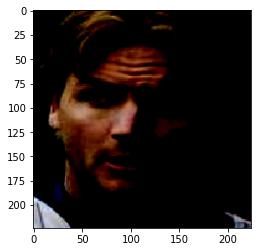

In [158]:
train_gen.reset()
train_gen.next()[0].shape

plt.imshow(train_gen.next()[0][25])

total batches: 601
epoch: 0 - batch: 0
x_train_batch: (32, 224, 224, 3) - y_train_batch: (32,)


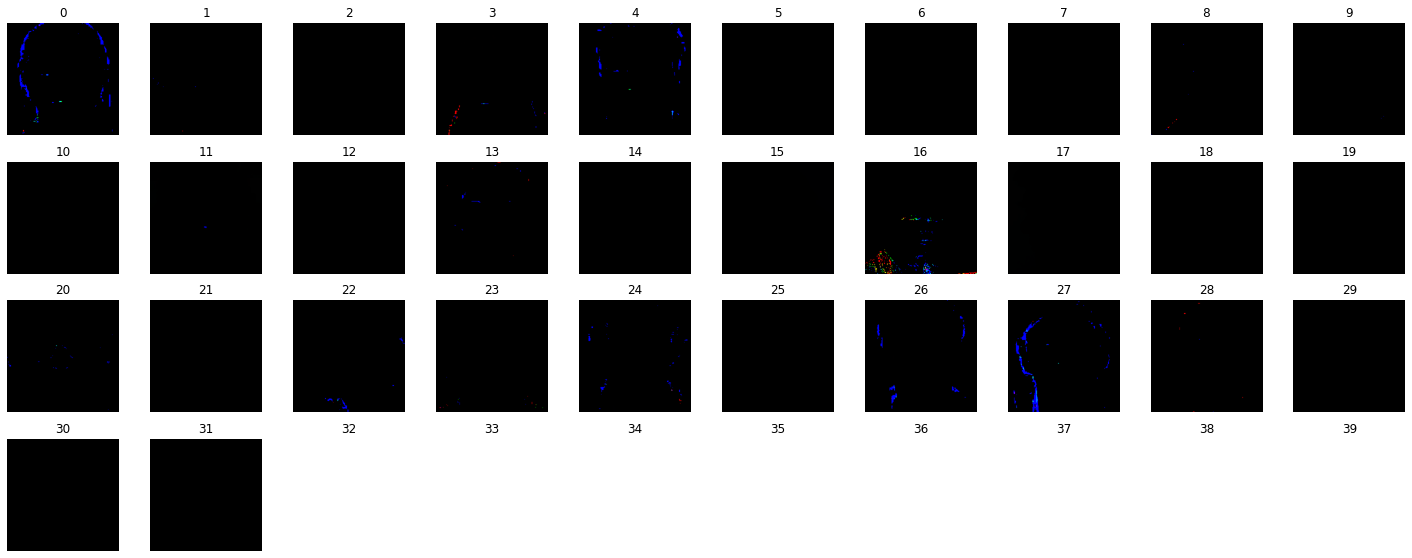

epoch: 0 - batch: 20
x_train_batch: (32, 224, 224, 3) - y_train_batch: (32,)


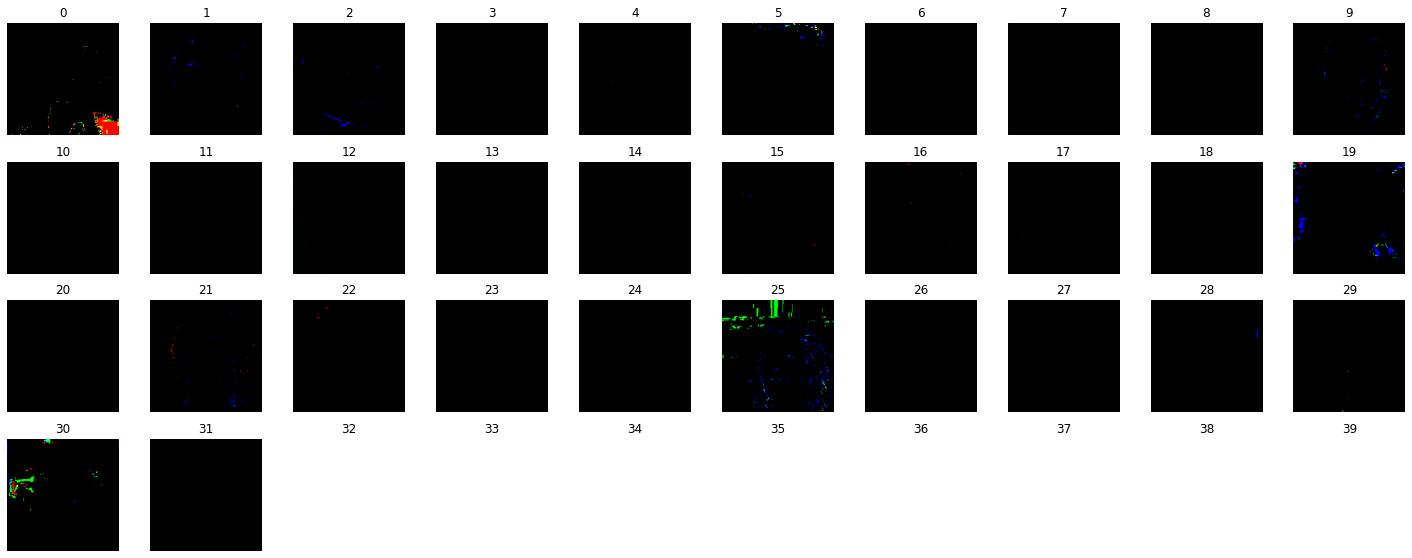

epoch: 0 - batch: 40
x_train_batch: (32, 224, 224, 3) - y_train_batch: (32,)


In [ ]:
print(f'total batches: {train_gen.n // BS}')
for epoch in range(1):
    n_batches = 0
    for idx, (x_train_batch, y_train_batch) in enumerate(train_gen):
        if n_batches % 20 == 0:
            print(f'epoch: {epoch} - batch: {n_batches}')
            print(f'x_train_batch: {x_train_batch.shape} - y_train_batch: {y_train_batch.shape}')
            dr.draw_imgs(x_train_batch)
#             display(plt.imshow(x_train_batch[idx]))
        
        if n_batches >= train_gen.n / BS:
            break
        
        n_batches += 1

In [ ]:
for e in range(EPOCHS):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in datagen. train_gen.flow(x_train, y_train, batch_size=32):
        model.fit(x_batch, y_batch)
        batches += 1
        if batches >= len(x_train) / 32:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

In [8]:
train_df = pd.DataFrame()
train_df['img_name'] = train_gen.filenames
train_df['label'] = train_gen.labels

n_comp_train = train_df[train_df.label == 1].shape[0]
n_non_comp_train = train_df[train_df.label == 0].shape[0]
n_total_train = train_df.shape[0]

print(f'N_COMP_TRAIN: {n_comp_train} ({round(n_comp_train/n_total_train * 100, 2)}%)')
print(f'N_NON_COMP_TRAIN: {n_non_comp_train} ({round(n_non_comp_train/n_total_train * 100, 2)}%)')

valid_df = pd.DataFrame()
valid_df['img_name'] = validation_gen.filenames
valid_df['label'] = validation_gen.labels

n_comp_valid = valid_df[valid_df.label == 1].shape[0]
n_non_comp_valid = valid_df[valid_df.label == 0].shape[0]
n_total_valid = valid_df.shape[0]

print(f'N_COMP_VALID: {n_comp_valid} ({round(n_comp_valid/n_total_valid * 100, 2)}%)')
print(f'N_NON_COMP_VALID: {n_non_comp_valid} ({round(n_non_comp_valid/n_total_valid * 100, 2)}%)')

test_df = pd.DataFrame()
test_df['img_name'] = test_gen.filenames
test_df['label'] = test_gen.labels

n_comp_test = test_df[test_df.label == 1].shape[0]
n_non_comp_test = test_df[test_df.label == 0].shape[0]
n_total_test = test_df.shape[0]

print(f'N_COMP_VALID: {n_comp_test} ({round(n_comp_test/n_total_test * 100, 2)}%)')
print(f'N_NON_COMP_VALID: {n_non_comp_test} ({round(n_non_comp_test/n_total_test * 100, 2)}%)')


N_COMP_TRAIN: 11619 (60.39%)
N_NON_COMP_TRAIN: 7621 (39.61%)
N_COMP_VALID: 2916 (60.62%)
N_NON_COMP_VALID: 1894 (39.38%)
N_COMP_VALID: 1593 (59.62%)
N_NON_COMP_VALID: 1079 (40.38%)


In [9]:
train_df['dataset'] = train_df.img_name.apply(lambda x : x.split('/')[8])
train_df.groupby('dataset').count()

,img_name,label
dataset,,
caltech_frontal_faces,360,360
celebA,2136,2136
colorferet,2548,2548
cvl,594,594
fei_database,292,292
georgiatech_db,557,557
icao_dataset,4155,4155
icpr_04_database,24,24
indian_facial_db,188,188


In [10]:
valid_df['dataset'] = valid_df.img_name.apply(lambda x : x.split('/')[8])
valid_df.groupby('dataset').count()

,img_name,label
dataset,,
caltech_frontal_faces,93,93
celebA,554,554
colorferet,650,650
cvl,139,139
fei_database,66,66
georgiatech_db,120,120
icao_dataset,1047,1047
icpr_04_database,5,5
indian_facial_db,48,48


In [11]:
test_df['dataset'] = test_df.img_name.apply(lambda x : x.split('/')[8])
test_df.groupby('dataset').count()

,img_name,label
dataset,,
caltech_frontal_faces,46,46
celebA,310,310
colorferet,356,356
cvl,67,67
fei_database,41,41
georgiatech_db,73,73
icao_dataset,578,578
icpr_04_database,1,1
indian_facial_db,34,34


## Training MobileNetV2

In [16]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
        train_gen,
        steps_per_epoch=train_gen.n // BS,
        validation_data=validation_gen,
        validation_steps=validation_gen.n // BS,
        epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/10
146/146 [==============================] - 42s 284ms/step - loss: 0.7213 - accuracy: 0.5081 - val_loss: 0.6932 - val_accuracy: 0.4175
Epoch 2/10
146/146 [==============================] - 41s 283ms/step - loss: 0.6932 - accuracy: 0.5066 - val_loss: 0.6931 - val_accuracy: 0.5138
Epoch 3/10
146/146 [==============================] - 41s 282ms/step - loss: 0.6932 - accuracy: 0.5141 - val_loss: 0.6931 - val_accuracy: 0.5063
Epoch 4/10
146/146 [==============================] - 41s 282ms/step - loss: 0.6931 - accuracy: 0.5124 - val_loss: 0.6931 - val_accuracy: 0.4787
Epoch 5/10
146/146 [==============================] - 41s 283ms/step - loss: 0.6931 - accuracy: 0.4859 - val_loss: 0.6931 - val_accuracy: 0.4350
Epoch 6/10
146/146 [==============================] - 42s 285ms/step - loss: 0.6931 - accuracy: 0.4704 - val_loss: 0.6931 - val_accuracy: 0.4638
Epoch 7/10
146/146 [==============================] - 41s 282ms/step - loss: 0.6

### Testing Trained Model

In [8]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(test_gen, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(test_gen.labels, predIdxs, target_names=['NON_COMP','COMP']))

[INFO] evaluating network...
              precision    recall  f1-score   support

    NON_COMP       0.62      0.03      0.06       802
        COMP       0.33      0.96      0.49       397

    accuracy                           0.34      1199
   macro avg       0.48      0.50      0.28      1199
weighted avg       0.53      0.34      0.20      1199



## Saving Model

In [9]:
# serialize the model to disk
print("[INFO] saving model...")
model.save(f"models/mouth_mobilenev2_model-{datetime.datetime.now()}.h5", save_format="h5")

[INFO] saving model...


## Plot Training Curves

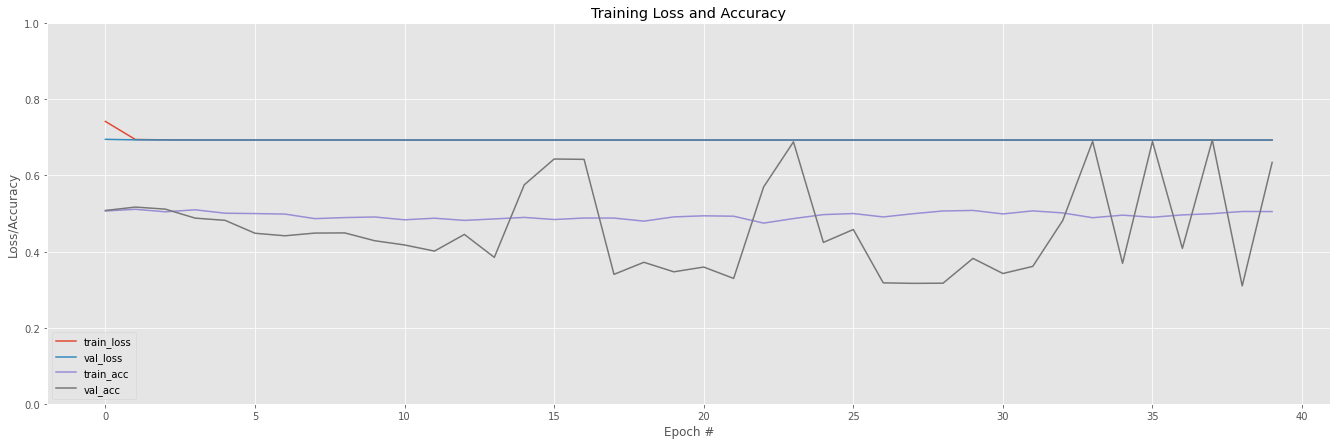

In [10]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure(figsize=(23,7))
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.ylim([0,1])
plt.legend(loc="lower left")
plt.savefig("figs/mouth_training_mobilenetv2.png")

## Training InceptionV3

In [15]:
datagen = ImageDataGenerator(preprocessing_function=prep_input_inceptionv3, 
                             validation_split=0.15)

train_gen = datagen.flow_from_dataframe(in_data[:15000], 
                                        x_col="img_name", 
                                        y_col="comp",
                                        target_size=(299, 299),
                                        class_mode="binary",
                                        batch_size=32, 
                                        shuffle=True,
                                        subset='training',
                                        seed=0)

validation_gen = datagen.flow_from_dataframe(in_data[:15000],
                                            x_col="img_name", 
                                            y_col="comp",
                                            target_size=(299, 299),
                                            class_mode="binary",
                                            batch_size=32, 
                                            shuffle=True,
                                            subset='validation',
                                            seed=0)

test_gen = datagen.flow_from_dataframe(in_data[15000:],
                                       x_col="img_name", 
                                       y_col="comp",
                                       target_size=(299, 299),
                                       class_mode="binary",
                                       batch_size=32, 
                                       shuffle=True,
                                       seed=0)

Found 12750 validated image filenames belonging to 2 classes.
Found 2250 validated image filenames belonging to 2 classes.
Found 1199 validated image filenames belonging to 2 classes.


In [16]:
INIT_LR = 1e-4
EPOCHS = 40
BS = 32  

# (trainX, testX, trainY, testY) = train_test_split(data, labels,
# 	test_size=0.20, stratify=labels, random_state=42)

# # construct the training image generator for data augmentation
# aug = ImageDataGenerator(
# 	rotation_range=20,
# 	zoom_range=0.15,
# 	width_shift_range=0.2,
# 	height_shift_range=0.2,
# 	shear_range=0.15,
# 	horizontal_flip=True,
# 	fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = InceptionV3(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(299, 299, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(8, 8))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	train_gen,
	steps_per_epoch=train_gen.n // BS,
	validation_data=validation_gen,
	validation_steps=validation_gen.n // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/40
398/398 [==============================] - 37s 93ms/step - loss: 0.6998 - accuracy: 0.4995 - val_loss: 0.6932 - val_accuracy: 0.4996
Epoch 2/40
398/398 [==============================] - 36s 90ms/step - loss: 0.6932 - accuracy: 0.5085 - val_loss: 0.6932 - val_accuracy: 0.5643
Epoch 3/40
398/398 [==============================] - 36s 91ms/step - loss: 0.6932 - accuracy: 0.5235 - val_loss: 0.6932 - val_accuracy: 0.5969
Epoch 4/40
398/398 [==============================] - 36s 91ms/step - loss: 0.6932 - accuracy: 0.5241 - val_loss: 0.6932 - val_accuracy: 0.6522
Epoch 5/40
398/398 [==============================] - 36s 90ms/step - loss: 0.6932 - accuracy: 0.5399 - val_loss: 0.6932 - val_accuracy: 0.6634
Epoch 6/40
398/398 [==============================] - 36s 91ms/step - loss: 0.6931 - accuracy: 0.5396 - val_loss: 0.6931 - val_accuracy: 0.6750
Epoch 7/40
398/398 [==============================] - 36s 91ms/step - loss: 0.6931 - a

### Testing Trained Model

In [17]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(test_gen, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(test_gen.labels, predIdxs, target_names=['NON_COMP','COMP']))

[INFO] evaluating network...
              precision    recall  f1-score   support

    NON_COMP       0.67      0.99      0.80       802
        COMP       0.36      0.01      0.02       397

    accuracy                           0.67      1199
   macro avg       0.51      0.50      0.41      1199
weighted avg       0.57      0.67      0.54      1199



## Saving Model

In [18]:
# serialize the model to disk
print("[INFO] saving model...")
model.save(f"models/mouth_inceptionv3_model-{datetime.datetime.now()}.h5", save_format="h5")

[INFO] saving model...


## Plot Training Curves

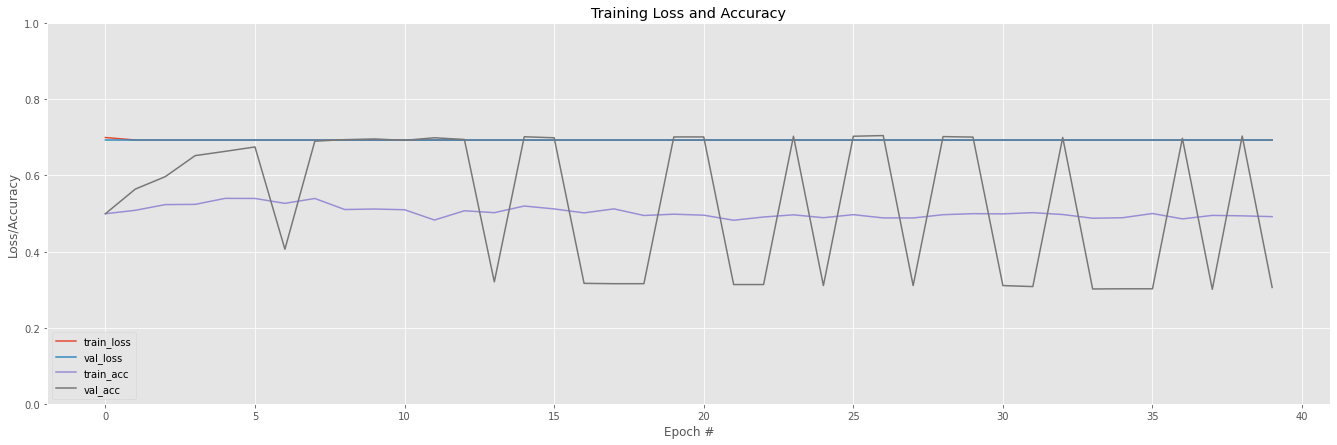

In [19]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure(figsize=(23,7))
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.ylim([0,1])
plt.legend(loc="lower left")
plt.savefig("figs/mouth_training_inceptionv3.png")